# **Bias measuring and mitigation in recommendation systems**

The bias problem can appear in models when the predictions systematically deviate from the true values for certain subgroups in the dataset. This phenomenon can occur due to various reasons such as unbalanced groups in the training data, feature selection, or model specification. Because of this, the bias problem can appear in different tasks, being "recommendation systems" one of them. A recommender system aims to recommend the best item according to the user preference.

There are various techniques to measure bias in recommendation systems. One common approach is to use fairness metrics such as aggregate diversity, exposure entropy, or gini index, which are item based metrics that, in general terms, calculate the distribution to observe the proportions of items are shown to the user.

Once bias is detected, we can employ different techniques to mitigate it. These methods can be grouped into three categories: Pre-processing, in-processing and post-processing methods. Pre-processing techniques are used to adjust the training data to remove bias, while in-processing methods are applied to build robust models against bias. Finally, post-processing techniques are used to adjust the model's predictions to remove bias.

A recommender system can be biased in multiple ways. For example, we may be concerned that the artists in our database will not get equal representation (item fairness). Alternative, our main concern may be that different groups of users (e.g. male/female users) will get different music recommendations (user fairness). In the following, we will show how to explore the data for fairness, and measure these various types of fairness using the holisticai library.

Through this tutorial, we pretend to present you tools which can be easily applied to measure and mitigate the presence of bias in recommender systems, by using a synthetic dataset that generates rankings of candidates using the Yang-Stoyanovich process.

We will follow the traditional outline for this tutorial:

1. Data loading and packages installation
2. Data exploration
3. Bias measuring
4. Bias mitigation
5. Results comparison

### **1. Data loading and packages installation**

In [26]:
# Base Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from holisticai.datasets.synthetic.recruitment import generate_rankings

The dataset that we will use is a synthetic ranking dataset generated following the procedure described by Yang and Stoyanovich in their [research](https://arxiv.org/abs/1610.08559). This algorithm creates a ranked output of protected and unprotected candidates with a certain probability.

To do that we will use the `generate_rankings` function that takes as arguments the number of `k` elements that will be generated for all the `M` lists under a probability `p` to be protected. 

For our case we will generate only one ranked list of 20 elements.

In [4]:
M = 1
k = 20
p = 0.1
ranking = generate_rankings(M, k, p)
ranking.head()

,X,Y,score,protected
0,0,20,20,False
1,0,19,19,True
2,0,18,18,False
3,0,17,17,False
4,0,16,16,False


To add bias into the dataset we will modify the `protected` column where the protected elements will be only the last six elements.

In [27]:
def create_unfair_example(ranking, n):
    """
    Setting an unfair ranking where protected group examples are only the last n results.
    """
    ranking = ranking.copy()
    ranking['protected']=False
    ranking['protected'].iloc[-n:]=True
    return ranking
    
unfair_ranking = create_unfair_example(ranking, 6)

In [7]:
unfair_ranking

,X,Y,score,protected
0,0,20,20,False
1,0,19,19,False
2,0,18,18,False
3,0,17,17,False
4,0,16,16,False
5,0,15,15,False
6,0,14,14,False
7,0,13,13,False
8,0,12,12,False
9,0,11,11,False


We now will create a new synthetic dataset to fit the mitigator which then will be used for the unfair dataset created previously.

From now on, we are going to assume that both rankings are outputs from a recommender system, and we will analyze the bias in the recommendations. Therefore, our purpose will be to measure and then  mitigate the bias in the recommendations.

In [8]:
# Synthetic data
M = 1000
top_n = 20
p = 0.25
rankings = generate_rankings(M, top_n, p, return_p_attr=False)

In [9]:
unfair_ranking.describe()

,X,Y,score
count,20.0,20.00000,20.00000
mean,0.0,10.50000,10.50000
std,0.0,5.91608,5.91608
min,0.0,1.00000,1.00000
25%,0.0,5.75000,5.75000
50%,0.0,10.50000,10.50000
75%,0.0,15.25000,15.25000
max,0.0,20.00000,20.00000


This graph show us that the proportion of men is very high compared to the female people.


In [10]:
rankings.describe()

,X,Y,score
count,20000.000000,20000.000000,20000.000000
mean,499.500000,10.500000,10.500000
std,288.682207,5.766425,5.766425
min,0.000000,1.000000,1.000000
25%,249.750000,5.750000,5.750000
50%,499.500000,10.500000,10.500000
75%,749.250000,15.250000,15.250000
max,999.000000,20.000000,20.000000


## **3. Dataset preprocessing**


We now need to change the dataframe to an interaction matrix, where every row is a user and every column is an artist. We can use the `recommender_formatter` function provided in the library which makes this transformation, then, the output dataframe can be used as an input to the bias metric functions for recommenders.


<Axes: title={'center': 'Group proportions'}>

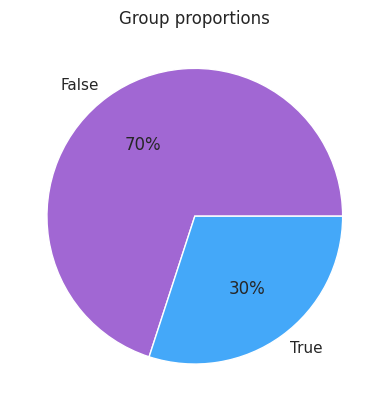

In [11]:
from holisticai.plots.bias import group_pie_plot, frequency_plot

group_pie_plot(unfair_ranking['protected'])

This graph show us that the proportion of the unprotected group is very high compared to the protected examples for the unfair dataset.

<Axes: title={'center': 'Group proportions'}>

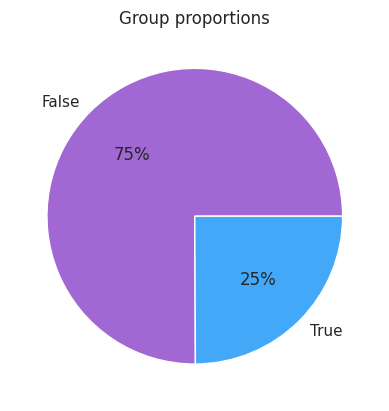

In [12]:
group_pie_plot(rankings['protected'])

A similar proportion is observed for the syntetic dataset, where the protected examples are only the 25% of the total data.

## **3. Bias measuring**

For these dataset we do not need to perform any preprocessing step, so we can use them directly to calculate the various metrics of fairness for recommender systems. In this example, we will use the `exposure_metric` function that calculates the exposure ratio and difference from the actual rankings for both datasets.

In [13]:
from holisticai.bias.mitigation.postprocessing.debiasing_exposure.algorithm_utils import exposure_metric

In [14]:
baseline = exposure_metric(rankings, group_col='protected', query_col='X', score_col='score')
baseline

,Value
exposure_ratio,33221.217929
exposure difference,0.048336


In [15]:
baseline_unfair = exposure_metric(unfair_ranking, group_col='protected', query_col='X', score_col='score')
baseline_unfair

,Value
exposure_ratio,516682.109793
exposure difference,0.103049


Above we have batch plotted some exposure based metrics for both datasets. For example:

*   **Exposure ratio:** Calculates the relation between the exposure of non-protected and protected elements from the dataset. For a fairer model we seek to have this value lower, indicating that the protected examples are gaining more exposure.
*   **Exposure difference:** Calculates the difference of exposure between the two groups this value will be zero when the protected group achieves more exposure than the non-protected.

## **4. Bias mitigation**

### **Post-processing: Disparate Impact Remover RS**

Now that we could observe that the metrics are far away from the desired values, we need to apply some kind of strategy to mitigate the bias present.

Exists different kinds of strategies, and the literature has divided them into three categories: "Pre-processing", "in-processing" and "post-processing" methods. The `holisticai` library possesses different algorithms from these categories for bias mitigation. An interesting feature is that all of them are compatible with the `Scikit-learn` package, so that, if you are familiar with this package, you will not have problems using the library.

For this opportunity, we will implement the "Disparate impact remover RS" method which is a postprocessing algorithm that edits feature values to increase group fairness while preserving rank-ordering within groups.

In [16]:
from holisticai.bias.mitigation import DisparateImpactRemoverRS

dir = DisparateImpactRemoverRS(query_col='X', group_col='protected', score_col='score', repair_level=1)

## **5. Compare results**
Now that we could observe how is the implementation of the mitigator, we will compare the results between the baseline and the implementations with the mitigator to analyse how the metrics have changed.

In [17]:
re_rankings = dir.transform(rankings)

Finally, we obtain our recommendation matrix:

In [18]:
df_dis_imp = exposure_metric(re_rankings, group_col='protected', query_col='X', score_col='score')
df_dis_imp

,Value
exposure_ratio,1.005388
exposure difference,0.001944


In [19]:
re_ranking = dir.transform(unfair_ranking)

In [20]:
df_dis_imp_unfair = exposure_metric(re_ranking, group_col='protected', query_col='X', score_col='score')
df_dis_imp_unfair

,Value
exposure_ratio,0.962027
exposure difference,0.000000


In [21]:
result = pd.concat([baseline, df_dis_imp], axis=1).iloc[:, [0,1]]
result.columns = ['Baseline','Mitigator']
result

,Baseline,Mitigator
exposure_ratio,33221.217929,1.005388
exposure difference,0.048336,0.001944


To perform the mitigation with this method we will use the data matrix calculated before with the protected groups

In [22]:
result = pd.concat([baseline_unfair, df_dis_imp_unfair], axis=1).iloc[:, [0,1]]
result.columns = ['Baseline','Mitigator']
result

,Baseline,Mitigator
exposure_ratio,516682.109793,0.962027
exposure difference,0.103049,0.000000


From the previous chart, we can see that certainly, an improvement is obtained by applying this method in the data, compared with our initial calculations for both datasets. 

Notice that we can analyse how these values are affected by varying the hyperparameters of the method.

For example, this method allows us to set a `repair_level` value which is a parameter to control the repair amount, where 0 means no repair while 1 is full repair.

Let's try with different values:

In [23]:
def calculate_metrics(data_matrix_, repair_level, metrics_cols):
  dir = DisparateImpactRemoverRS(query_col='X', group_col='protected', score_col='score', repair_level=repair_level)
  new_ranking_ = dir.transform(data_matrix_)
  df = exposure_metric(new_ranking_, group_col='protected', query_col='X', score_col='score')
  # Calculate metrics
  metrics = [
      repair_level,
  ]
  metrics.extend([df['Value'].loc[col] for col in metrics_cols])
  return metrics

In [24]:
metrics_val = []
metrics_cols = ["exposure_ratio", "exposure difference"]

for repair_values in np.linspace(0,1,6):
  metrics_val.append(calculate_metrics(unfair_ranking, repair_values, metrics_cols))

metrics = ['repair_level']
metrics.extend(metrics_cols)
df_metrics = pd.DataFrame(metrics_val, columns=metrics)
df_metrics

,repair_level,exposure_ratio,exposure difference
0,0.0,516682.109793,0.103049
1,0.2,27926.612806,0.103044
2,0.4,2200.646756,0.102983
3,0.6,190.992596,0.102281
4,0.8,15.232911,0.093650
5,1.0,0.962027,0.000000


Text(0.5, 0, 'Gamma')

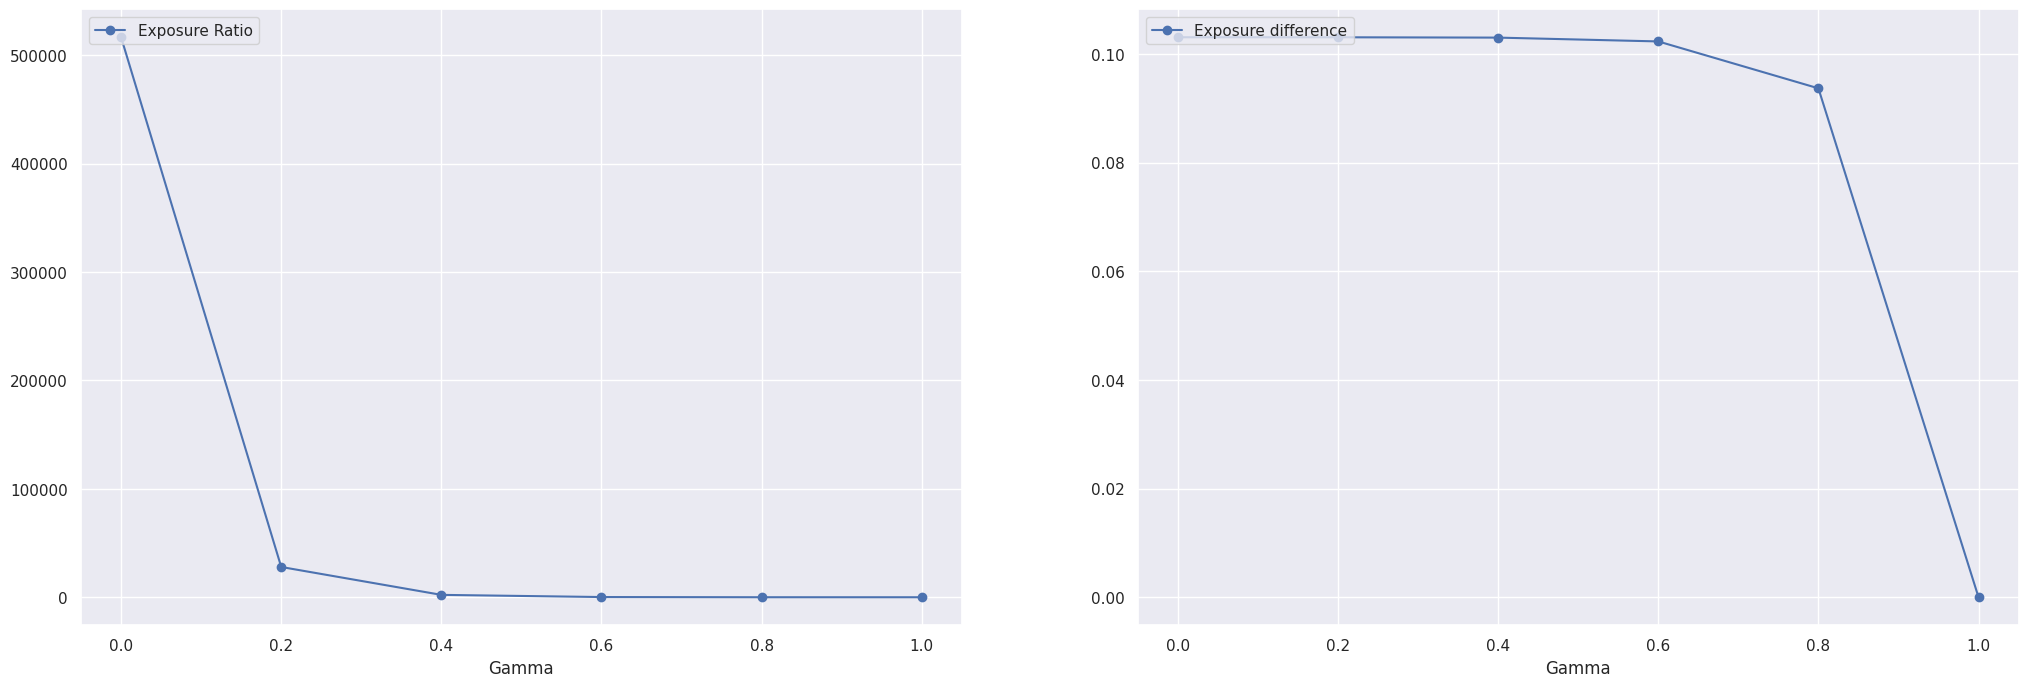

In [25]:
x_axis = df_metrics.repair_level
plt.figure(figsize=(25,8))
plt.subplot(121)
plt.plot(x_axis, df_metrics['exposure_ratio'], 'o-', label='Exposure Ratio')
plt.legend(loc='upper left')
plt.xlabel('Gamma')
plt.subplot(122)
plt.plot(x_axis, df_metrics['exposure difference'], 'o-', label='Exposure difference')
plt.legend(loc='upper left')
plt.xlabel('Gamma')

As expected, as the `repair_value` parameter increases, we get a better model in terms of fairness. In general, the selection of the model parameters will depend on our main objective.

# **Summary**

Through this tutorial we could present to the user how the `holisticai` library can be easily used to measure the bias present in recommender systems by the application of the `exposure_metric` function, which returns the calculated values for different metrics.

In addition, we shown how to mitigate the bias by applying some methods, for this opportunity we applied the "Disparate impact Remover RS" technique to increase the fairness of the ranked list, this is a post-processing method that edits feature values to increase group fairness. Consequently we could observe how the metrics are influenced by varing the *repair level* parameter, and showing that this method increases the fairness of the model.
